In [1]:
import sys
import os
import random
import gc
import time
import torch
import numpy as np
import pandas as pd
import ast
from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr, kendalltau, rankdata
from sklearn.metrics import ndcg_score
from transformers import AutoModelForCausalLM, AutoTokenizer
from accelerate import Accelerator

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from SHapRAG import *

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df= pd.read_csv("../data/synthetic_data/20_synergy_hard_negatives.csv",index_col=False, sep=";")
# df= pd.read_csv("../data/complementary.csv")

In [ ]:
df.context[1]

In [ ]:
docs = [
# "The weather in Chorvoq is stormy today.",
"Chorvoq is the capital of Narniya.",
# "The sun is shining in Galaba today",
"Nurik is the capital of Suvsambil.",
"Narniya borders several countries including Suvsambil.",
"The currency used in Narniya is the Euro.",
"Narniya is the biggest country in the Olam",
# "Chorvoq hosted the Summer Olympics in 1900 and 1924.",
"The capital of Narniya is Chorvoq.",
# "Suvsambil uses the Euro as well.",
"It is cloudy in Nurik today."
]
query = "What is the capital of the biggest country in the Olam?"
# Parameters
NUM_RETRIEVED_DOCS = len(docs)


In [3]:
SEED = 42
# Initialize Accelerator
accelerator_main = Accelerator(mixed_precision="fp16")

# Load Model
if accelerator_main.is_main_process:
    print("Main Script: Loading model...")
# model_path = "mistralai/Mistral-7B-Instruct-v0.3"
# model_path = "meta-llama/Llama-3.1-8B-Instruct"
model_path = "Qwen/Qwen2.5-3B-Instruct"

model_cpu = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model_cpu.config.pad_token_id = tokenizer.pad_token_id
    if hasattr(model_cpu, 'generation_config') and model_cpu.generation_config is not None:
        model_cpu.generation_config.pad_token_id = tokenizer.pad_token_id

if accelerator_main.is_main_process:
    print("Main Script: Preparing model with Accelerator...")
prepared_model = accelerator_main.prepare(model_cpu)
unwrapped_prepared_model = accelerator_main.unwrap_model(prepared_model)
unwrapped_prepared_model.eval()
if accelerator_main.is_main_process:
    print("Main Script: Model prepared and set to eval.")

# Define utility cache

accelerator_main.wait_for_everyone()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Main Script: Loading model...


Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


Main Script: Preparing model with Accelerator...
Main Script: Model prepared and set to eval.


In [4]:
num_questions_to_run=len(df.question)
# num_questions_to_run=1
all_metrics_data = []
all_results=[]
M=[]
Fs=[]
pairs=[]
mse_inters=[]
mse_lins=[]
mse_fms=[]
for i in tqdm(range(num_questions_to_run), desc="Processing Questions", disable=not accelerator_main.is_main_process):
    query = df.question[i]
    if accelerator_main.is_main_process:
        print(f"\n--- Question {i+1}/{num_questions_to_run}: {query[:60]}... ---")

    docs=ast.literal_eval(df.context[i])

    utility_cache_base_dir = "../Experiment_data/synergy"
    utility_cache_filename = f"utilities_q_idx{i}_n{len(docs)}.pkl" # More robust naming
    current_utility_path = os.path.join(utility_cache_base_dir, utility_cache_filename)
    
    if accelerator_main.is_main_process: # Only main process creates directories
        os.makedirs(os.path.dirname(current_utility_path), exist_ok=True)
        print(f"  Instantiating ShapleyExperimentHarness for Q{i} (n={len(docs)} docs)...")
    
    # Initialize Harness
    harness = ContextAttribution(
        items=docs,
        query=query,
        prepared_model_for_harness=prepared_model,
        tokenizer_for_harness=tokenizer,
        accelerator_for_harness=accelerator_main,
        verbose=False
    )
    # Compute metrics
    results_for_query = {}
    # M.append(harness.compute_shapley_interaction_index_pairs_matrix())
    if accelerator_main.is_main_process:

        # results_for_query["ExactLinear"], mse_lin = harness.compute_exact_linear_shap()
        # results_for_query["ExactInter"], pair, mse_inter = harness.compute_exact_inter_shap()
        # pairs.append(pair)
        # mse_lins.append(mse_lin)
        # mse_inters.append(mse_inter)
        m_samples_map = {"L": 32} 
        T_iterations_map = { "L":20} 

        for size_key, num_s in m_samples_map.items():
            if 2**len(docs) < num_s and size_key != "L":
                actual_samples = max(1, 2**len(docs)-1 if 2**len(docs)>0 else 1)
            else:
                actual_samples = num_s

            if actual_samples > 0: 
                results_for_query[f"ContextCite{actual_samples}"] = harness.compute_contextcite(num_samples=actual_samples, seed=SEED)
                results_for_query[f"WSS_FM{actual_samples}"], F, mse_fm = harness.compute_wss(num_samples=actual_samples, seed=SEED)
                Fs.append(F)
                mse_fms.append(mse_fm)
                results_for_query[f"BetaShap{actual_samples}"] = harness.compute_beta_shap(num_iterations_max=T_iterations_map[size_key], beta_a=4, beta_b=4, max_unique_lookups=actual_samples, seed=SEED)
                results_for_query[f"TMC{actual_samples}"] = harness.compute_tmc_shap(num_iterations_max=T_iterations_map[size_key], performance_tolerance=0.001, max_unique_lookups=actual_samples, seed=SEED)

        results_for_query["LOO"] = harness.compute_loo()
        results_for_query["ARC-JSD"] = harness.compute_arc_jsd()

        # exact_scores = results_for_query.get("ExactInter")
        all_results.append(results_for_query)
#         if exact_scores is not None:
#             positive_exact_score = np.clip(exact_scores, a_min=0.0, a_max=None) # FOR NDGC SCORE COMPUTATION
#             for method, approx_scores in results_for_query.items():
#                 if method != "Exact" and approx_scores is not None:
#                     if len(approx_scores) == len(exact_scores):
#                         if np.all(exact_scores == exact_scores[0]) or np.all(approx_scores == approx_scores[0]):
#                             pearson_c = 1.0 if np.allclose(exact_scores, approx_scores) else 0.0
#                             spearman_c = 1.0 if np.allclose(exact_scores, approx_scores) else 0.0
#                         else:
#                             pearson_c, _ = pearsonr(exact_scores, approx_scores)
#                             exact_ranks = rankdata(-np.array(exact_scores), method="average") # rank scores with the smallest =1 and when there is a tie assign the average rank
#                             approx_ranks = rankdata(-np.array(approx_scores), method = "average")
#                             kendall_c, _ = kendalltau(exact_ranks, approx_ranks) # return tau and pval (if pval is < 0.005 we can say that correlation is statistically significant) 
                        
#                         all_metrics_data.append({
#                             "Question_Index": i, "Query": query, "Method": method,
#                             "Pearson": pearson_c, "KendallTau" : kendall_c,
#                         })
#                     else:
#                         print(f"    Score length mismatch for method {method} (Exact: {len(exact_scores)}, Approx: {len(approx_scores)}). Skipping metrics.")
#         else:
#             print(f"    Skipping metric calculation for Q{i} as Exact Shapley was not computed or failed.")
    
#     accelerator_main.wait_for_everyone() 
   
#     if torch.cuda.is_available():
#         if accelerator_main.is_main_process: # Print from one process
#             print(f"Attempting to empty CUDA cache on rank {accelerator_main.process_index} after Q{i}")
#         torch.cuda.empty_cache()
#         gc.collect()
#         if accelerator_main.is_main_process:
#             print(f"CUDA cache empty attempt complete on rank {accelerator_main.process_index}.")
#     accelerator_main.wait_for_everyone()


# if accelerator_main.is_main_process:
#     if all_metrics_data:
#         metrics_df_all_questions = pd.DataFrame(all_metrics_data)
#         print("\n\n--- Average Correlation Metrics Across All Questions ---")
#         average_metrics = metrics_df_all_questions.groupby("Method").agg(
#             Avg_Pearson=("Pearson", "mean"),
#             Avg_Kendall =("KendallTau", "mean"),
#             Num_Valid_Queries=("Query", "nunique")
#         ).sort_values(by="Avg_Pearson", ascending=False)
        
#         print(average_metrics.round(4))
#     else:
#         print("\nNo metrics were collected. This might be due to all calculations failing or only non-main processes running sections.")

# # Final synchronization before script ends
# accelerator_main.wait_for_everyone()
# if accelerator_main.is_main_process:
#     print("Script finished.")

# if torch.distributed.is_available() and torch.distributed.is_initialized():
#     if accelerator_main.is_local_main_process:
#         print(f"Rank {accelerator_main.process_index} (Local Main): Manually destroying process group...")
#     torch.distributed.destroy_process_group()
#     if accelerator_main.is_local_main_process:
#         print(f"Rank {accelerator_main.process_index} (Local Main): Process group destroyed.")
# else:
#     if accelerator_main.is_local_main_process:
#         print(f"Rank {accelerator_main.process_index} (Local Main): Distributed environment not initialized or not available, skipping destroy_process_group.")

# if accelerator_main.is_main_process:
#     print("Script fully exited.")

Processing Questions:   0%|          | 0/20 [00:00<?, ?it/s]


--- Question 1/20: What kind of energy does the facility hovering the planet Xy... ---
  Instantiating ShapleyExperimentHarness for Q0 (n=10 docs)...


/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
Processing Questions:   5%|▌         | 1/20 [00:09<02:52,  9.09s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_samp


--- Question 2/20: What is the primary defense of the creatures populating the ... ---
  Instantiating ShapleyExperimentHarness for Q1 (n=10 docs)...


Processing Questions:  10%|█         | 2/20 [00:15<02:17,  7.63s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 3/20: What is the main function of the device recently discovered ... ---
  Instantiating ShapleyExperimentHarness for Q2 (n=10 docs)...


Processing Questions:  15%|█▌        | 3/20 [00:22<02:02,  7.20s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 4/20: What is the composition of the natural wonder of planet Ntun... ---
  Instantiating ShapleyExperimentHarness for Q3 (n=10 docs)...


Processing Questions:  20%|██        | 4/20 [00:30<02:02,  7.65s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 5/20: What is the traditional weapon of the defenders of the Citad... ---
  Instantiating ShapleyExperimentHarness for Q4 (n=10 docs)...


Processing Questions:  25%|██▌       | 5/20 [00:37<01:49,  7.27s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 6/20: What kind of power source is used by the ancient constructs ... ---
  Instantiating ShapleyExperimentHarness for Q5 (n=10 docs)...


Processing Questions:  30%|███       | 6/20 [00:44<01:40,  7.19s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 7/20: What is the primary ingredient of the most famous healing po... ---
  Instantiating ShapleyExperimentHarness for Q6 (n=10 docs)...


Processing Questions:  35%|███▌      | 7/20 [00:51<01:32,  7.08s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 8/20: What defensive ability is possessed by the strongest creatur... ---
  Instantiating ShapleyExperimentHarness for Q7 (n=10 docs)...


Processing Questions:  40%|████      | 8/20 [00:58<01:25,  7.09s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 9/20: What is the energy source of the massive orbital platform or... ---
  Instantiating ShapleyExperimentHarness for Q8 (n=10 docs)...


Processing Questions:  45%|████▌     | 9/20 [01:05<01:17,  7.04s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 10/20: What is the population of the capital of the biggest country... ---
  Instantiating ShapleyExperimentHarness for Q9 (n=10 docs)...


Processing Questions:  50%|█████     | 10/20 [01:11<01:09,  6.95s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 11/20: What's the weather like in the capital of Zhykara?... ---
  Instantiating ShapleyExperimentHarness for Q10 (n=10 docs)...


Processing Questions:  55%|█████▌    | 11/20 [01:18<01:00,  6.76s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 12/20: What's the value of the element obtained by mixing Aethelite... ---
  Instantiating ShapleyExperimentHarness for Q11 (n=10 docs)...


Processing Questions:  60%|██████    | 12/20 [01:25<00:55,  6.99s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 13/20: What's the side effect of mixing Gravitium and Solara?... ---
  Instantiating ShapleyExperimentHarness for Q12 (n=10 docs)...


Processing Questions:  65%|██████▌   | 13/20 [01:32<00:48,  6.99s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 14/20: What is the radius of the largest planet in the K'tharr Syst... ---
  Instantiating ShapleyExperimentHarness for Q13 (n=10 docs)...


Processing Questions:  70%|███████   | 14/20 [01:39<00:41,  6.86s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 15/20: What is the population of the smallest planet in the Lumina ... ---
  Instantiating ShapleyExperimentHarness for Q14 (n=10 docs)...


Processing Questions:  75%|███████▌  | 15/20 [01:45<00:33,  6.74s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 16/20: What is the title of the latest film starring the highest-pa... ---
  Instantiating ShapleyExperimentHarness for Q15 (n=10 docs)...


Processing Questions:  80%|████████  | 16/20 [01:52<00:26,  6.72s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 17/20: What is the salary of the most popular actor on the planet A... ---
  Instantiating ShapleyExperimentHarness for Q16 (n=10 docs)...


Processing Questions:  85%|████████▌ | 17/20 [01:59<00:19,  6.64s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 18/20: What is the title of the first album by the most popular Chr... ---
  Instantiating ShapleyExperimentHarness for Q17 (n=10 docs)...


Processing Questions:  90%|█████████ | 18/20 [02:05<00:13,  6.57s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 19/20: What is the total number of plays for the most critically ap... ---
  Instantiating ShapleyExperimentHarness for Q18 (n=10 docs)...


Processing Questions:  95%|█████████▌| 19/20 [02:11<00:06,  6.57s/it]/transformers/src/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/transformers/src/transformers/generation/configuration_utils.py:658: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(



--- Question 20/20: What is the effect of drinking water from the sacred spring ... ---
  Instantiating ShapleyExperimentHarness for Q19 (n=10 docs)...


Processing Questions: 100%|██████████| 20/20 [02:18<00:00,  6.93s/it]


In [5]:
results_for_query

{'ContextCite32': array([ 0.58684029,  0.82485679,  0.03443105,  0.00414971,  0.06067532,
        -0.        ,  0.0572419 ,  0.2321265 , -0.14221312,  0.31278131]),
 'WSS_FM32': array([ 0.93576554,  0.75511215,  0.09289398,  0.08998644, -0.0863729 ,
        -0.07648611,  0.05832539,  0.0891132 ,  0.18688753,  0.00350298]),
 'BetaShap32': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'TMC32': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'LOO': array([2.16484380e+00, 2.16484380e+00, 3.21245074e-01, 3.91070008e-01,
        5.17821312e-02, 1.18490219e-01, 9.66787338e-04, 3.69970798e-02,
        2.61602521e-01, 1.57176733e-01]),
 'ARC-JSD': [1.0519842382322686,
  2.1481132729937116,
  0.23250397900771747,
  0.22340687799260728,
  0.12797545891348783,
  0.14085358204743592,
  0.02695908257433466,
  0.16733498533736046,
  0.16634214985933937,
  0.2540038756698859]}

In [ ]:
print(f"Interaction: {mse_inters},\n Linear: {mse_lins},\n FM: {mse_fms}")

In [ ]:
print(f"Interaction: {sum(mse_inters)},\n Linear: {sum(mse_lins)},\n FM: {sum(mse_fms)}")


In [ ]:
harness.compute_exhaustive_top_k(2)

In [ ]:
M[8]

In [ ]:
# Evaluate metrics
all_metrics_data = []
exact_scores = results_for_query.get("Exact")
if exact_scores is not None:
    positive_exact_score = np.clip(exact_scores, a_min=0.0, a_max=None)
    for method, approx_scores in results_for_query.items():
        if method != "Exact" and approx_scores is not None and len(approx_scores) == len(exact_scores):
            if np.all(exact_scores == exact_scores[0]) or np.all(approx_scores == approx_scores[0]):
                pearson_c = spearman_c = 1.0 if np.allclose(exact_scores, approx_scores) else 0.0
            else:
                pearson_c, _ = pearsonr(exact_scores, approx_scores)
                spearman_c, _ = spearmanr(exact_scores, approx_scores)
                exact_ranks = rankdata(-np.array(exact_scores), method="average")
                approx_ranks = rankdata(-np.array(approx_scores), method="average")
                kendall_c, _ = kendalltau(exact_ranks, approx_ranks)
            ndgc_scoring = ndcg_score([positive_exact_score], [approx_scores], k=3)

            all_metrics_data.append({
                    "Method": method,
                "Pearson": pearson_c, "Spearman": spearman_c, "NDCG": ndgc_scoring, "KendallTau": kendall_c
            })
            all_metrics_data.sort(key=lambda x: x["Pearson"], reverse=True)


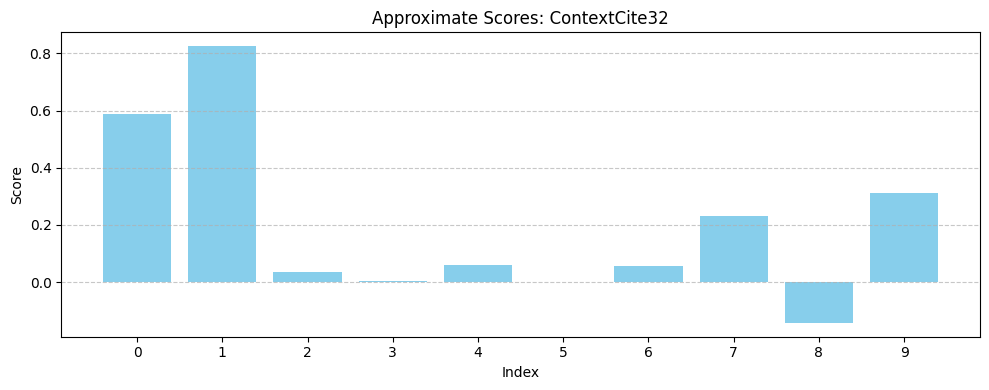

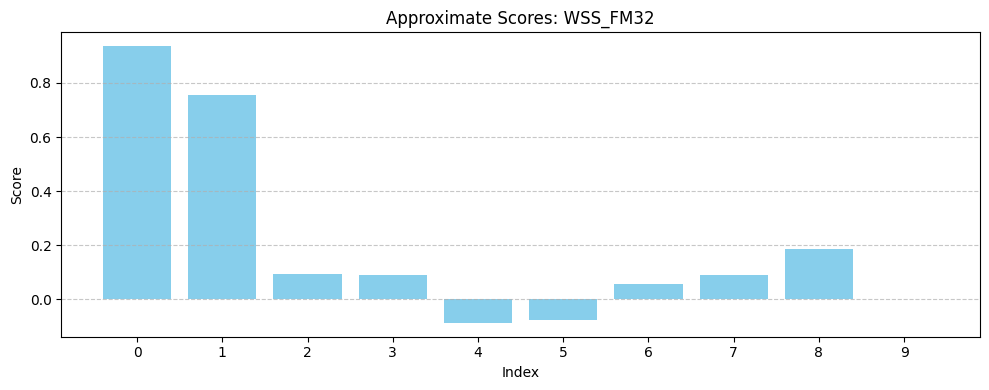

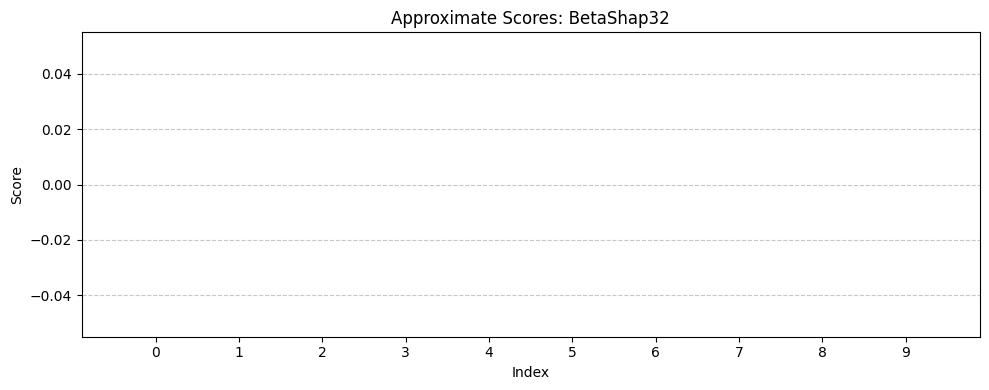

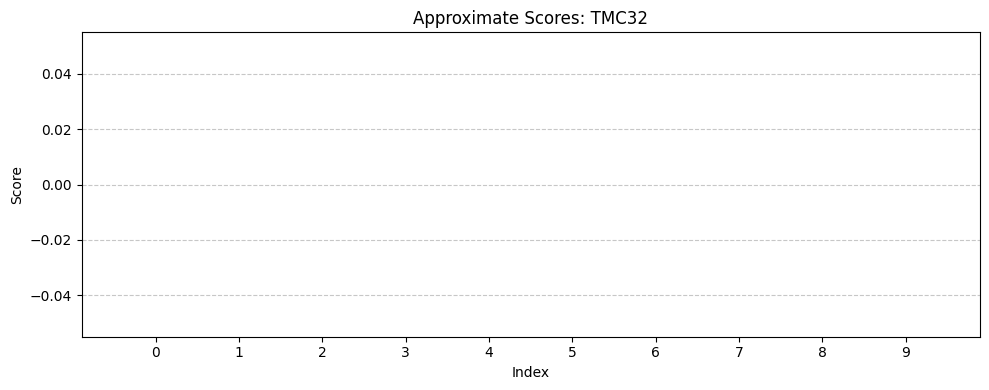

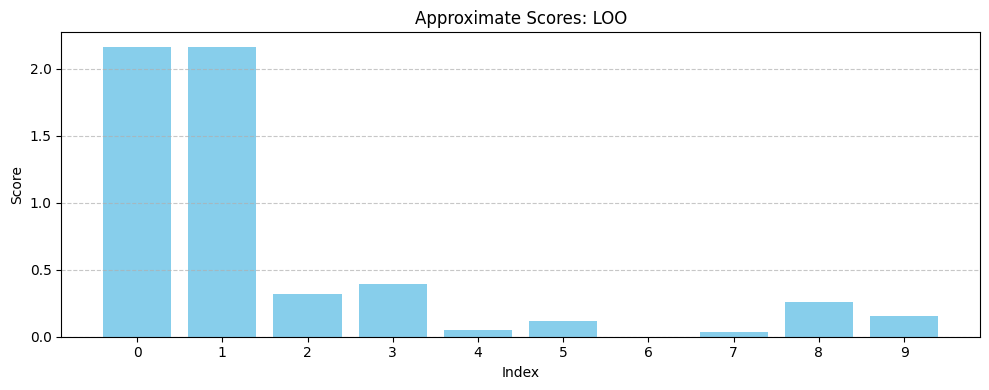

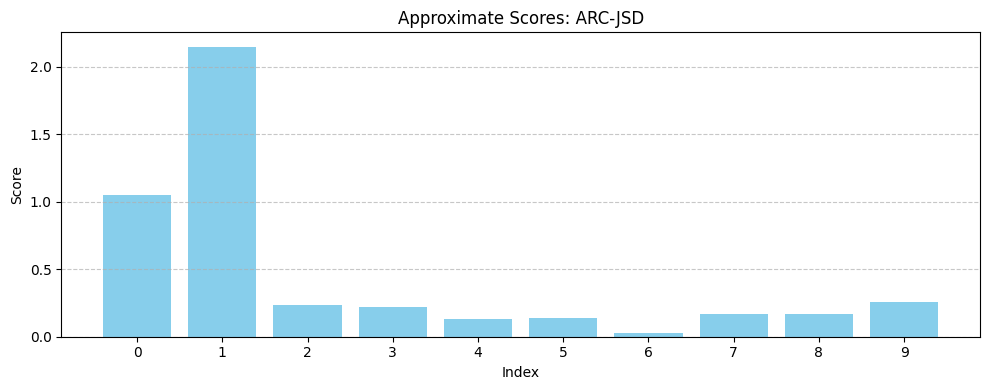

In [6]:
import matplotlib.pyplot as plt

method_scores = {}

for result in all_results:
    for method, scores in result.items():
        if scores is not None:
            method_scores[method] = np.round(scores, 4)

for method, scores in method_scores.items():
    plt.figure(figsize=(10, 4))
    plt.bar(range(len(scores)), scores, color='skyblue')
    plt.title(f"Approximate Scores: {method}")
    plt.xlabel("Index")
    plt.ylabel("Score")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(range(len(scores)))
    plt.tight_layout()
    plt.show()


In [ ]:
F[1]

In [ ]:
df.context[19]